In [6]:
import pandas as pd
import tensorflow as tf
import torch
from utils.fnSampling import get_random_sample_directory,get_processed_sample
pd.set_option("display.max_colwidth", None)
spam_dataset = pd.read_parquet('./data/datasets/baselines/4chan/spam_dataset.parquet')
# Baseline training dataset - used to train the classifer
SMS_dataset = pd.read_csv('./data/datasets/baselines/SMS/SMSSpamCollection_cleaned.csv')
email_dataset = pd.read_csv('./data/datasets/baselines/email/email_spam.csv')

Num GPUs Available: 1
Is cuda available: True
Tensorflow: 2.13.0


### Baseline Model Development using Public Data
- https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
- https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset

Error processing row 2966: expected string or bytes-like object


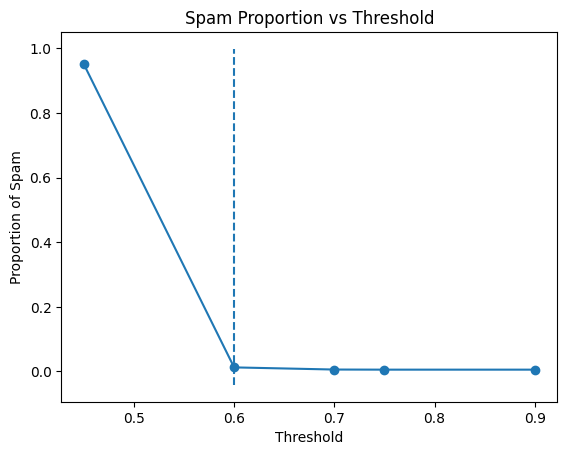

Optimal threshold for significant drop-off: 0.6
Error processing row 2966: expected string or bytes-like object
spam_label
SPAM        0.717333
NOT_SPAM    0.282000
ERROR       0.000333
            0.000333
Name: proportion, dtype: float64


In [46]:
import logging
import pandas as pd
from utils import fnSampling 
from utils import fnTesting
from srcs.labeler import DialogDetector,apply_detector
from utils.fnProcessing import remove_urls,remove_whitespace
# Configure logging
logging.basicConfig(level=logging.INFO)
# Copy dataframe loaded above and run threshold analysis
data = email_dataset.copy()  
params = {
    'sample_size': [len(data)],
    'similarity_threshold': [0.45,0.6,0.7,0.75,0.9]
}
data["text_clean"] = data["text_clean"].astype(str).apply(remove_urls).astype(str).apply(remove_whitespace).astype(str)
optimal_threshold, results , summary_table = fnTesting.evaluate_spam_threshold(data, params)
# Perform clustering and visualize the results
# Reduced the threshold by 0.1 since it removed too many messages
spam_ratio, dialog_data, similarity_training_data, spam_detector = apply_detector(data, .5, len(data))
print(spam_ratio)

Example interpretation of the above breakdown: 
- **NOT_SPAM: 72.0%**: The proportion classified as not spam.
- **SPAM: 28.2%**: The proportion classified as spam.
- **Unlabeled:<0.00%**: The proportion of the sample that is not classified as either spam or not spam. This unlabeled segment is then passed to the UTA algorithm for classification.
- **ERROR:<0.00%**: The proportion errored out during the classification process.

ROC AUC Score for Classifier: 0.6359751628382957


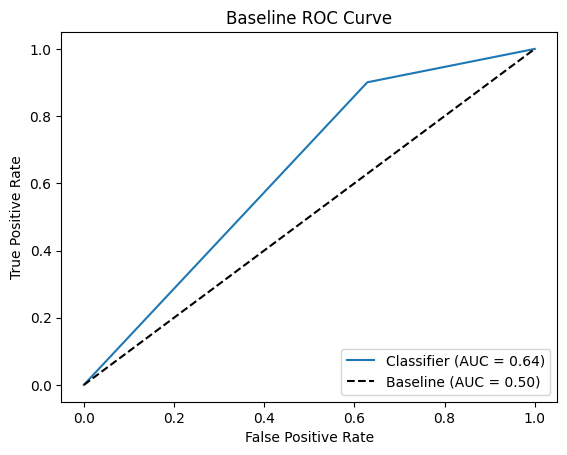

In [48]:
from utils.fnTesting import test_roc
test_roc(dialog_data)

cluster
0     0.966825
1     0.041667
2     0.543590
3     0.473684
4     1.000000
5     0.854167
6     0.688547
7     0.568182
8     0.808176
9     0.562500
10    0.265625
11    0.460317
12    0.585714
13    0.781780
14    0.500000
15    0.930052
16    0.582734
17    0.111111
Name: spam_label, dtype: float64


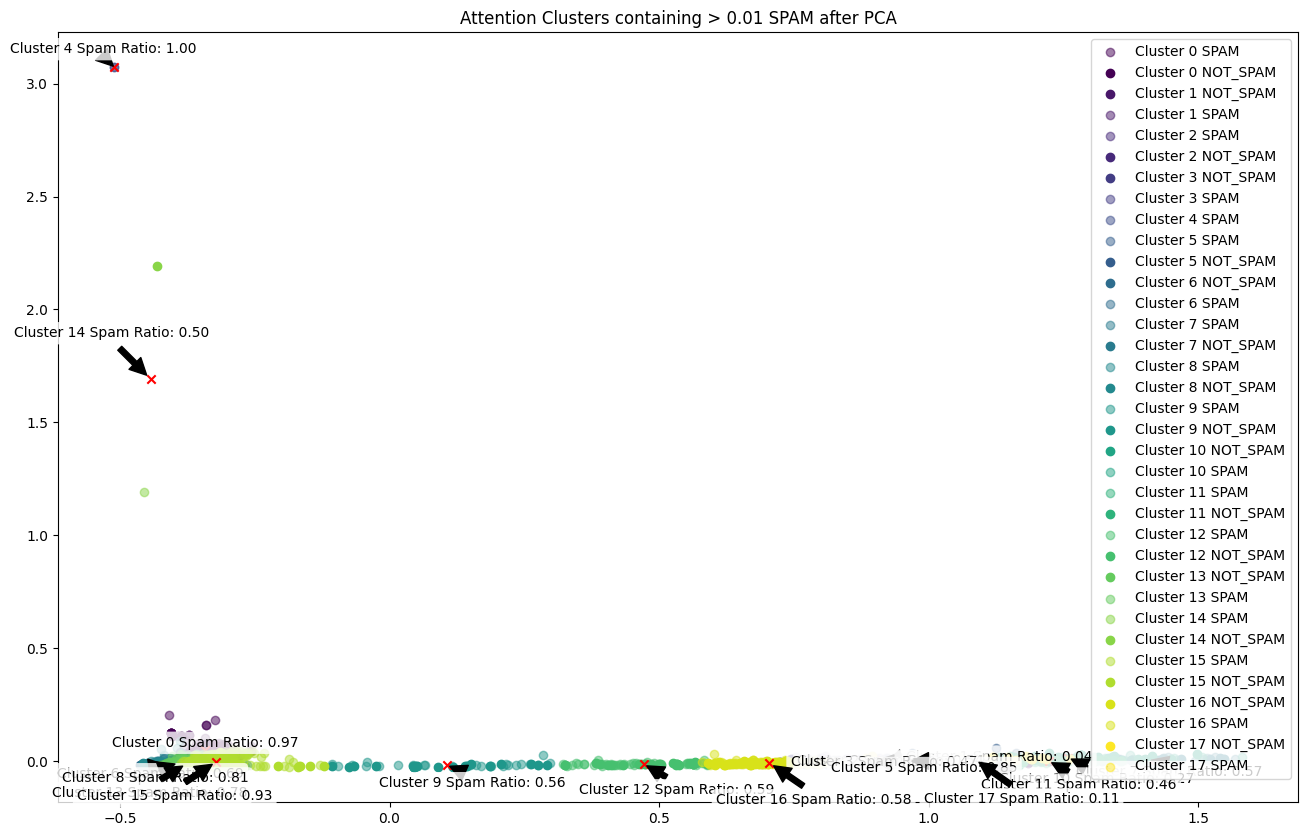

In [50]:
from srcs import attention_filter
fig, cluster_junk_ratio, data_clustered = attention_filter.main_plotting(dialog_data, max_length=512, show_scatter=True)

# Identify clusters with a specific spam ratio and filter the data for further classification
spam_clusters = cluster_junk_ratio[cluster_junk_ratio > 0.4].index.tolist()
certanty_data = data_clustered[~data_clustered['cluster'].isin(spam_clusters) & ~data_clustered['spam_label'].isin([''])]

ROC AUC Score for Classifier: 0.6363636363636364


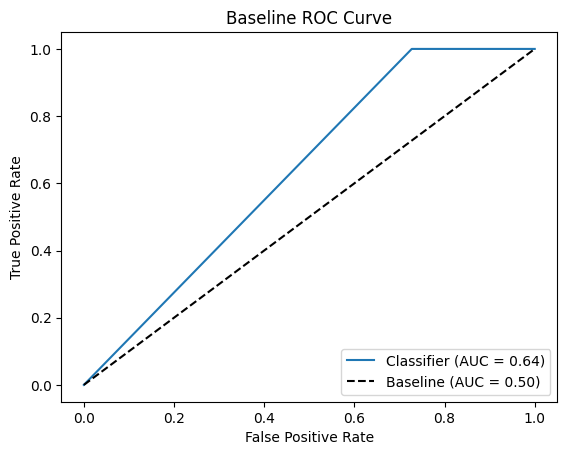

In [67]:
test_roc(certanty_data)

#### Step 3: Training and Preparing the Classifier

In [68]:
# The following code prepares the training data for the classification task and trains the model. The model is stored for use in the proceeding uncertainty estimation task.
import numpy as np
from srcs.classifier import classifier
from srcs.classifier import load_classifier
from srcs.classifier import UST_trainer
from utils.fnPlots import plot_history
from sklearn.preprocessing import LabelEncoder
from transformers import BertModel, BertTokenizer

params = {
    'epochs': 10,
    'batch_size': 5,
    'layers': [32,32,32,32],
    'dropout': 0.1,
    'batch_normalization': True,
    'l1_reg': 0.0015,
    'l2_reg': 0.0015,
    'initial_learning_rate': 0.00125,
    'decay_steps': 10000,
    'decay_rate': 0.96,
    'T': 15
}
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name, output_attentions=True)

tokenizer = BertTokenizer.from_pretrained(model_name)

# Load and process the training data
data_path = './data/datasets/baselines/email/splits'
load_classifier.load_and_split_data_smote(spam_dataset, 'spam_label', output_folder=data_path)
# Process new data
data_dict, max_length = classifier.load_and_process_data(data_path)
train_data = np.stack(data_dict['train']['vector'].values)
val_data = np.stack(data_dict['val']['vector'].values)
test_data = np.stack(data_dict['test']['vector'].values)
train_labels = data_dict['train']['spam_label'].values
val_labels = data_dict['val']['spam_label'].values
test_labels = data_dict['test']['spam_label'].values
# Initialize the encoder
encoder = LabelEncoder()
# Fit the encoder and transform the labels
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

# Convert the numpy arrays into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
train_dataset = train_dataset.batch(params['batch_size'])
val_dataset = val_dataset.batch(params['batch_size'])
test_dataset = test_dataset.batch(params['batch_size'])

# Define the spam clusters and classifier object as needed
history, original_model = classifier.train_model(train_data, train_labels, val_data, val_labels, params)
# Run UST on the clustered data. Remember that this data has can be assumed to be confidently labeled after going through similarity threshold method and clustering. The classifer will now predict the label to improve the overall performance of the model. 
data_clustered['spam_label'] = ''
final_model, evaluation_metrics, final_histories = UST_trainer.self_train(train_data, train_labels, val_data, val_labels, data_clustered, params, spam_clusters, classifier)

2023-08-17 16:26:27.966233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-17 16:26:27.966874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-17 16:26:27.967070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-17 16:26:33.473058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-17 16:26:33.475058: I tensorflow/compile

Epoch 1/10


2023-08-17 16:26:44.761508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-17 16:26:44.910059: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f60ac021ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-17 16:26:44.910103: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-08-17 16:26:45.024545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-17 16:26:45.775869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-17 16:26:46.154090: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

9/9 [==============================] - ETA: 0s - loss: 2.7902 - accuracy: 0.6504INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 10s 219ms/step - loss: 2.7902 - accuracy: 0.6504 - val_loss: 2.6181 - val_accuracy: 0.8136 - lr: 0.0012
Epoch 2/10
5/9 [===============>..............] - ETA: 0s - loss: 2.3477 - accuracy: 0.8313INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 144ms/step - loss: 2.2515 - accuracy: 0.8571 - val_loss: 2.3698 - val_accuracy: 0.8136 - lr: 0.0012
Epoch 3/10
7/9 [======================>.......] - ETA: 0s - loss: 1.9828 - accuracy: 0.8750INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 183ms/step - loss: 1.9716 - accuracy: 0.8609 - val_loss: 2.1469 - val_accuracy: 0.7797 - lr: 0.0012
Epoch 4/10
7/9 [======================>.......] - ETA: 0s - loss: 1.7636 - accuracy: 0.9062INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 137ms/step - loss: 1.7506 - accuracy: 0.8947 - val_loss: 1.9488 - val_accuracy: 0.8136 - lr: 0.0012
Epoch 5/10
7/9 [======================>.......] - ETA: 0s - loss: 1.5486 - accuracy: 0.9018INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 141ms/step - loss: 1.5439 - accuracy: 0.9023 - val_loss: 1.7897 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 6/10
7/9 [======================>.......] - ETA: 0s - loss: 1.4198 - accuracy: 0.9062INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 140ms/step - loss: 1.4091 - accuracy: 0.9098 - val_loss: 1.6538 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 7/10
7/9 [======================>.......] - ETA: 0s - loss: 1.2845 - accuracy: 0.9107INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 180ms/step - loss: 1.3016 - accuracy: 0.9098 - val_loss: 1.5506 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 8/10
7/9 [======================>.......] - ETA: 0s - loss: 1.2369 - accuracy: 0.8973INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 138ms/step - loss: 1.2265 - accuracy: 0.9023 - val_loss: 1.4700 - val_accuracy: 0.8814 - lr: 0.0012
Epoch 9/10
7/9 [======================>.......] - ETA: 0s - loss: 1.1689 - accuracy: 0.8884INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 137ms/step - loss: 1.1576 - accuracy: 0.8910 - val_loss: 1.4210 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 10/10
6/9 [===================>..........] - ETA: 0s - loss: 1.0939 - accuracy: 0.9167INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 139ms/step - loss: 1.0927 - accuracy: 0.9173 - val_loss: 1.3939 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 1/10
7/9 [======================>.......] - ETA: 0s - loss: 2.6885 - accuracy: 0.7277 INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 4s 151ms/step - loss: 2.6273 - accuracy: 0.7519 - val_loss: 2.6311 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 2/10
8/9 [=========================>....] - ETA: 0s - loss: 2.1978 - accuracy: 0.8516INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 133ms/step - loss: 2.1990 - accuracy: 0.8459 - val_loss: 2.3556 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 3/10
7/9 [======================>.......] - ETA: 0s - loss: 2.0049 - accuracy: 0.8482INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 137ms/step - loss: 2.0005 - accuracy: 0.8496 - val_loss: 2.1264 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 4/10
7/9 [======================>.......] - ETA: 0s - loss: 1.7706 - accuracy: 0.8482INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 177ms/step - loss: 1.7511 - accuracy: 0.8459 - val_loss: 1.9351 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 5/10
7/9 [======================>.......] - ETA: 0s - loss: 1.5743 - accuracy: 0.8616INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 133ms/step - loss: 1.5432 - accuracy: 0.8684 - val_loss: 1.7651 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 6/10
8/9 [=========================>....] - ETA: 0s - loss: 1.4185 - accuracy: 0.8672INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 136ms/step - loss: 1.4120 - accuracy: 0.8722 - val_loss: 1.6199 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 7/10
7/9 [======================>.......] - ETA: 0s - loss: 1.2712 - accuracy: 0.8973INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 137ms/step - loss: 1.2593 - accuracy: 0.8985 - val_loss: 1.5070 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 8/10
8/9 [=========================>....] - ETA: 0s - loss: 1.1927 - accuracy: 0.9102INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 178ms/step - loss: 1.1998 - accuracy: 0.9060 - val_loss: 1.4476 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 9/10
8/9 [=========================>....] - ETA: 0s - loss: 1.0937 - accuracy: 0.9219INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 133ms/step - loss: 1.0885 - accuracy: 0.9248 - val_loss: 1.3963 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 10/10
7/9 [======================>.......] - ETA: 0s - loss: 1.0557 - accuracy: 0.9152INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 133ms/step - loss: 1.0769 - accuracy: 0.9135 - val_loss: 1.3713 - val_accuracy: 0.8475 - lr: 0.0012
INFO:tensorflow:Assets written to: saved_models/student_model_0.tf/assets


INFO:tensorflow:Assets written to: saved_models/student_model_0.tf/assets


94/94 [==============================] - 0s 2ms/step


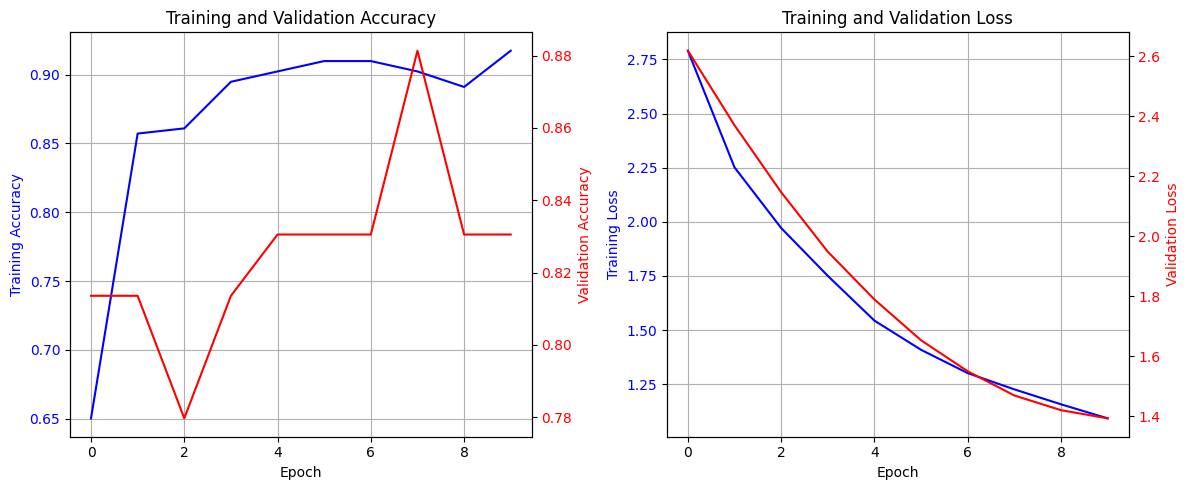

2/2 [==============================] - 0s 6ms/step - loss: 1.3684 - accuracy: 0.9322
Test Loss: 1.3684207201004028
Test Accuracy: 0.9322034120559692
1/1 [==============================] - 0s 61ms/step
Sample Labels: [1 1 0 1 0 1 1 0 1 1]
Sample Predictions: [[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]]


In [69]:
plot_history(history)
# Evaluate on test set
test_loss, test_acc = original_model.evaluate(test_data, test_labels, verbose=1)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Sample predictions
sample_data = test_data[:10]
sample_labels = test_labels[:10]
sample_predictions = original_model.predict(sample_data)
sample_predictions = (sample_predictions > 0.5).astype(int) # Thresholding
print('Sample Labels:', sample_labels)
print('Sample Predictions:', sample_predictions)

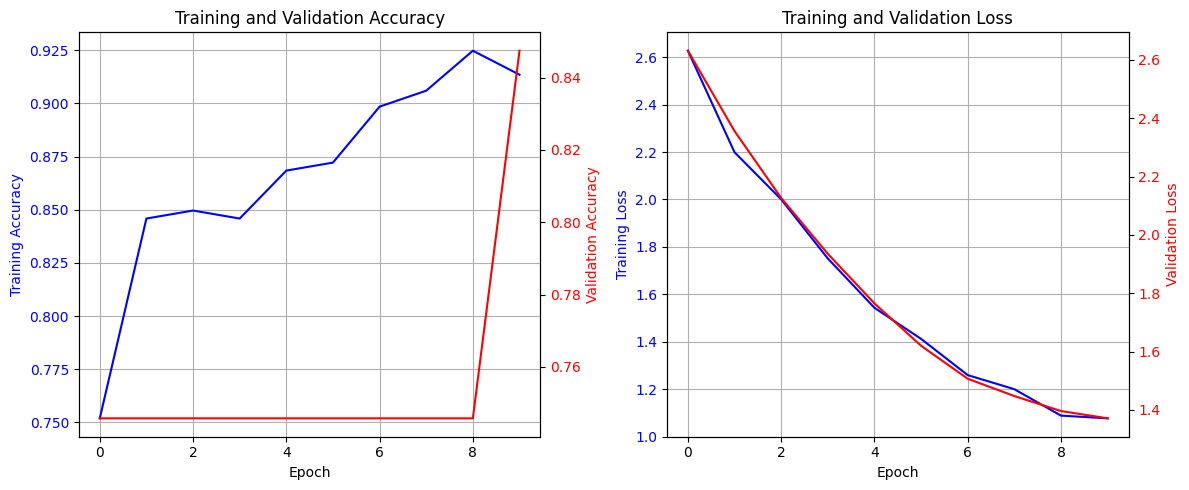

2/2 - 0s - loss: 0.9446 - accuracy: 0.9492 - 30ms/epoch - 15ms/step
Test Loss: 0.9446474313735962
Test Accuracy: 0.9491525292396545
1/1 [==============================] - 0s 64ms/step
Sample Labels: [1 1 0 1 0 1 1 0 1 1]
Sample Predictions: [[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]]


In [70]:
plot_history(final_histories[-1]) # Use the appropriate history object for final model
# Evaluate on test set
test_loss, test_acc = final_model.evaluate(test_data, test_labels, verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
# Sample predictions
sample_data = test_data[:10]
sample_labels = test_labels[:10]
sample_predictions = final_model.predict(sample_data)
sample_predictions = (sample_predictions > 0.5).astype(int)
print('Sample Labels:', sample_labels)
print('Sample Predictions:', sample_predictions)

#### The model performance improves on the test set after UST, demonstrating two things:
1. The model can generize
2. UST is effective in improving the model performance